In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import io
import os
from sklearn import linear_model
from scipy import interpolate
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D


from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras import optimizers

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.layers import Activation
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

In [2]:
rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [8, 6]

In [3]:
# dogs vs. cats
dogdata_w_mat = io.loadmat(os.path.join('Data','dogData_w.mat'))
catdata_w_mat = io.loadmat(os.path.join('Data','catData_w.mat'))

dog_wave = dogdata_w_mat['dog_wave']
cat_wave = catdata_w_mat['cat_wave']

CD = np.concatenate((dog_wave,cat_wave),axis=1)

train = np.concatenate((dog_wave[:,:60],cat_wave[:,:60]),axis=1)
test = np.concatenate((dog_wave[:,60:80],cat_wave[:,60:80]),axis=1)
label = np.repeat(np.array([1,-1]),60)

A = label @ np.linalg.pinv(train)
test_labels = np.sign(A@test)

In [4]:
lasso = linear_model.Lasso().fit(train.T,label)
A_lasso = lasso.coef_
test_labels_lasso = np.sign(A_lasso@test)

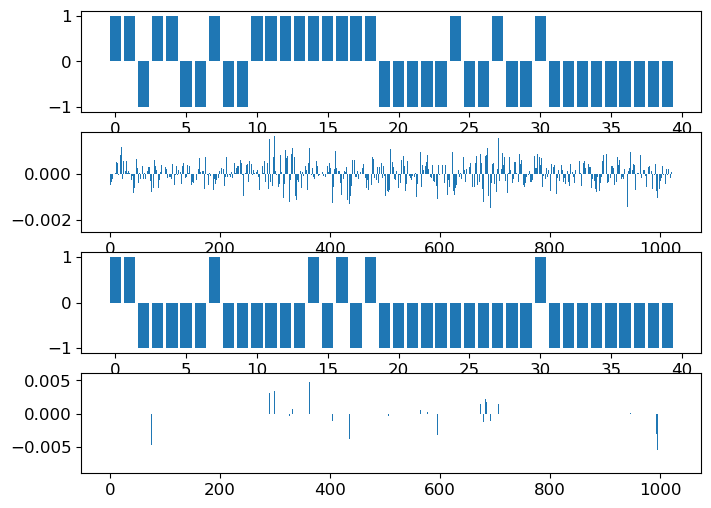

In [5]:
fig,axs = plt.subplots(4,1)
axs[0].bar(range(len(test_labels)),test_labels)
axs[1].bar(range(len(A)),A)
axs[2].bar(range(len(test_labels_lasso)),test_labels_lasso)
axs[3].bar(range(len(A_lasso)),A_lasso)


plt.show()

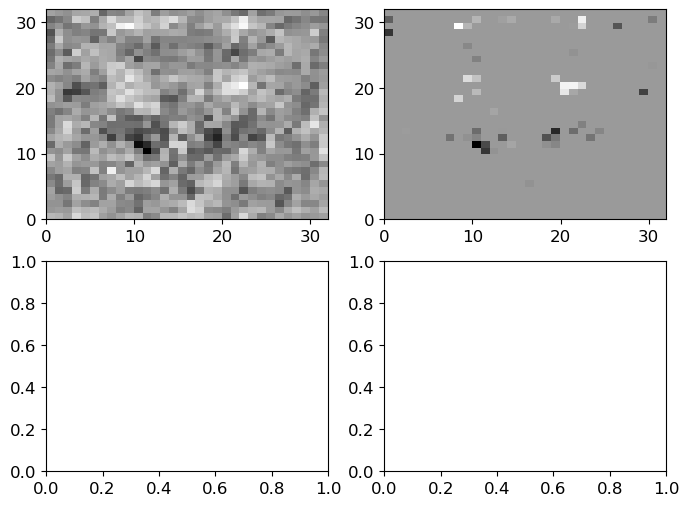

In [6]:
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
A2 = np.flipud(np.reshape(A,(32,32)))
A2_lasso = np.flipud(np.reshape(A_lasso,(32,32)))
axs[0].pcolor(np.rot90(A2),cmap='gray')
axs[1].pcolor(np.rot90(A2_lasso),cmap='gray')


plt.show()

## Stochatic Gradient Descent

In [9]:
iterMax = 100
h = 0.1
x_grid = np.arange(-6, 6+h, h)
y_grid = np.copy(x_grid)
n = len(x_grid)
X, Y = np.meshgrid(x_grid, y_grid)

F1 = 1.5 - 1.6*np.exp(-0.05*(3*np.power(X+3, 2)+np.power(Y+3, 2)))
F = F1 + (0.5 - np.exp(-0.1*(3*np.power(X-3, 2)+np.power(Y-3, 2))))
dFy, dFx = np.gradient(F, h, h)

x0 = np.array([4, 0, -5])
y0 = np.array([0, -5, 2])

x = np.zeros(iterMax+1)
y = np.copy(x)
f = np.copy(x)

x_out = np.zeros((iterMax+1, 3))
y_out = np.copy(x_out)
f_out = np.copy(x_out)

interp_type = 'linear'

for jj in range(3):
    q = np.random.permutation(n)
    i1 = np.sort(q[:10])
    q2 = np.random.permutation(n)
    i2 = np.sort(q2[:10])
    x[0] = x0[jj]
    y[0] = y0[jj]

    F_i12 = F[i1[:, np.newaxis], i2]
    dFx_i12 = dFx[i1[:, np.newaxis], i2]
    dFy_i12 = dFy[i1[:, np.newaxis], i2]

    F_interp = interpolate.interp2d(
        x_grid[i1], y_grid[i2], F_i12, kind=interp_type)
    dfx_interp = interpolate.interp2d(
        x_grid[i1], y_grid[i2], dFx_i12, kind=interp_type)
    dfy_interp = interpolate.interp2d(
        x_grid[i1], y_grid[i2], dFy_i12, kind=interp_type)

    f[0] = F_interp(x[0], y[0])
    dfx = dfx_interp(x[0], y[0])
    dfy = dfy_interp(x[0], y[0])

#     tau = 2
    tau = 1.5
    for j in range(iterMax):
        x[j+1] = x[j]-tau*dfx  # update x, y, and f
        y[j+1] = y[j]-tau*dfy
        q = np.random.permutation(n)
        i1 = np.sort(q[:10])
#         ind1 = np.sort(q[:10])
        q2 = np.random.permutation(n)
        i2 = np.sort(q2[:10])
#         ind2 = np.sort(q2[:10])

        F_interp = interpolate.interp2d(
            x_grid[i1], y_grid[i2], F_i12, kind=interp_type)
        dfx_interp = interpolate.interp2d(
            x_grid[i1], y_grid[i2], dFx_i12, kind=interp_type)
        dfy_interp = interpolate.interp2d(
            x_grid[i1], y_grid[i2], dFy_i12, kind=interp_type)

        f[j+1] = F_interp(x[j+1], y[j+1])
        dfx = dfx_interp(x[j+1], y[j+1])
        dfy = dfy_interp(x[j+1], y[j+1])

        if np.abs(f[j+1]-f[j]) < 10**(-6):  # check convergence
            print('Converged after {} iterations'.format(j+1))
            break
        if j == iterMax-1:
            print('Failed to converge after {} iterations'.format(j+1))
    x_out[:, jj] = x
    y_out[:, jj] = y
    f_out[:, jj] = f

    # If converged before iterMax, replace 0s with NaNs
    x_out[(j+2):, jj] = np.nan
    y_out[(j+2):, jj] = np.nan
    f_out[(j+2):, jj] = np.nan


C:\Users\Guilh\AppData\Local\Temp\ipykernel_18936\1236125212.py:37: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  F_interp = interpolate.interp2d(
C:\Users\Guilh\AppData\Local\Temp\ipykernel_18936\1236125212.py:39: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `

Failed to converge after 100 iterations
Failed to converge after 100 iterations
Failed to converge after 100 iterations


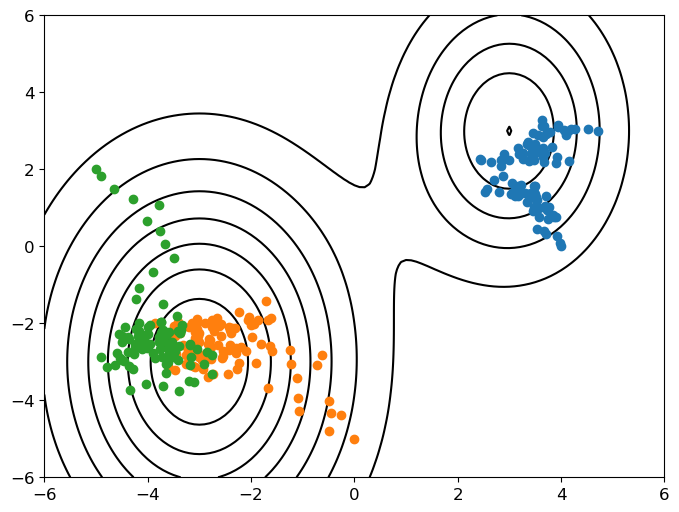

In [10]:
plt.figure()
plt.contour(X, Y, F, colors='k')
for jj in range(3):
    plt.plot(x_out[:, jj], y_out[:, jj], 'o')
plt.show()


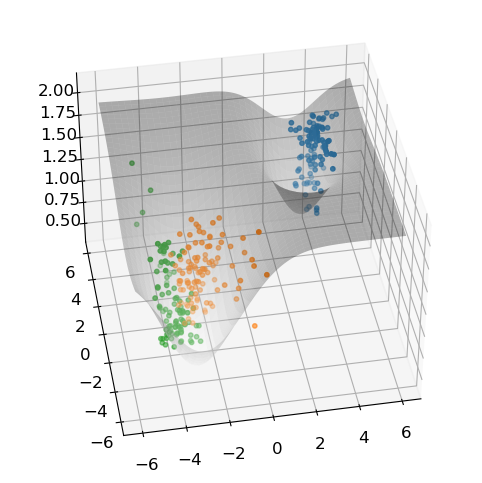

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.plot_surface(X, Y, F, linewidth=0, cmap='binary', alpha=0.3)
for jj in range(3):
    ax.scatter(x_out[:, jj], y_out[:, jj], f_out[:, jj]+0.1, 'o', s=10)
ax.view_init(elev=40, azim=-100)
plt.show()


## Convolution Neural Networks

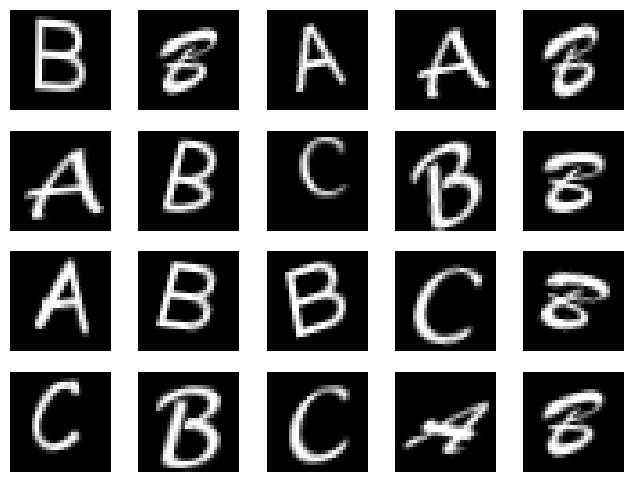

In [16]:
letters_train_mat = io.loadmat(
    os.path.join('Data', 'lettersTrainSet.mat'))
letters_test_mat = io.loadmat(os.path.join('Data', 'lettersTestSet.mat'))
XTrain = letters_train_mat['XTrain']
TTrain = letters_train_mat['TTrain_cell']
XTest = letters_test_mat['XTest']
TTest = letters_test_mat['TTest_cell']

perm = np.random.permutation(1500)[:20]


# By default, Keras expects data in form (batch, height, width, channels)
XTrain = np.transpose(XTrain, axes=[3, 0, 1, 2])
XTest = np.transpose(XTest, axes=[3, 0, 1, 2])


fig, axs = plt.subplots(4, 5)
axs = axs.reshape(-1)

for j in range(len(axs)):
    axs[j].imshow(np.squeeze(XTrain[perm[j], :, :, :]), cmap='gray')
    axs[j].axis('off')


In [17]:
classes = np.unique(TTrain)
y_train_label = np.zeros_like(TTrain)
y_test_label = np.zeros_like(TTest)
for nc in range(len(classes)):
    y_train_label[TTrain == classes[nc]] = nc
    y_test_label[TTest == classes[nc]] = nc

y_train_label = y_train_label.reshape(-1)
y_test_label = y_test_label.reshape(-1)

# one-hot encode categorical classes
y_train = to_categorical(y_train_label)
y_test = to_categorical(y_test_label)


In [18]:
# create model
model = Sequential()

# add model layers
model.add(Conv2D(filters=16, kernel_size=5,
          activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(len(classes), activation='softmax'))

sgd_optimizer = optimizers.SGD(momentum=0.9)
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy')
model.fit(XTrain, y_train, epochs=30)


Epoch 1/30
47/47 [==============================] - 4s 44ms/step - loss: 0.4508
Epoch 2/30
47/47 [==============================] - 2s 34ms/step - loss: 0.0422
Epoch 3/30
47/47 [==============================] - 2s 46ms/step - loss: 0.0174
Epoch 4/30
47/47 [==============================] - 1s 31ms/step - loss: 0.0104
Epoch 5/30
47/47 [==============================] - 1s 27ms/step - loss: 0.0074
Epoch 6/30
47/47 [==============================] - 2s 47ms/step - loss: 0.0057
Epoch 7/30
47/47 [==============================] - 2s 45ms/step - loss: 0.0047
Epoch 8/30
47/47 [==============================] - 2s 42ms/step - loss: 0.0038
Epoch 9/30
47/47 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 10/30
47/47 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 11/30
47/47 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 12/30
47/47 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 13/30
47/47 [=====================

In [19]:
YPredict = np.argmax(model.predict(XTest), axis=1)
# argmax reverses the one-hot encoding scheme

accuracy = np.sum(YPredict == y_test_label)/len(y_test_label)
print('Accuracy = {}'.format(accuracy))


47/47 [==============================] - 1s 4ms/step
Accuracy = 0.8893333333333333
